In [2]:
import jax
import jax.numpy as jnp
import jax.random as random
import optax
import scipy as sp

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.cm as cm


import sys
import os
sys.path.append('../')
# sys.path.append('../power_law_rf')
import optimizers
#import power_law_rf as plrf
import power_law_rf.power_law_rf as plrf
from power_law_rf.power_law_rf import PowerLawRF
from power_law_rf.ode import ode_resolvent_log_implicit
from power_law_rf.ode import DanaHparams
from power_law_rf.ode import ODEInputs#
from power_law_rf.least_squares import lsq_streaming_optax_simple
import power_law_rf.deterministic_equivalent as theory

key = random.PRNGKey(0)

In [3]:
ALPHA = 0.4
BETA = 0.7
V = 2000
D = 500
SGDBATCH=1
STEPS = 10**6
key, subkey = random.split(key)
problem = PowerLawRF.initialize_random(alpha=ALPHA, beta=BETA, v=V, d=D, key=subkey)
g1 = optimizers.powerlaw_schedule(1.0, 0.0, 0.0, 1)
g2 = optimizers.powerlaw_schedule(0.5/problem.population_trace, 0.0, 0.0, 1)
g3 = optimizers.powerlaw_schedule(1.0/problem.population_trace, 0.0, -1.0/(2*problem.alpha), 1)
Delta = optimizers.powerlaw_schedule(1.0, 0.0, -1.0, 4.0+2*(problem.alpha+problem.beta)/(2*problem.alpha))
danadecayopt = optimizers.dana_optimizer(g1=g1,g2=g2,g3=g3,Delta=Delta)

In [11]:
#pls = powerlaw_schedule(0.5/problem.population_trace, 0.0, -0.5, 1)
key, newkey = random.split(key)
danadecaytimes,danadecaylosses = lsq_streaming_optax_simple(newkey, 
                         problem.get_data, 
                         SGDBATCH, 
                         STEPS, 
                         danadecayopt, 
                         jnp.zeros((problem.d,1)), 
                         problem.get_population_risk)

100%|██████████| 130/130 [01:30<00:00,  1.43it/s]


In [4]:
#Initialize the rhos
initTheta = jnp.zeros(problem.d, dtype=jnp.float32)
initY = jnp.zeros(problem.d, dtype=jnp.float32)
rho_init = problem.get_rhos()
sigma_init = jnp.zeros_like(rho_init)
chi_init = jnp.zeros_like(rho_init)

Keigs = problem.get_hessian_spectra()
riskInftyTheory=problem.get_theory_limit_loss()

Dt = 10**(-2)

odeTimes_dana_decay2, odeRisks_dana_decay2 = ode_resolvent_log_implicit(
    ODEInputs(Keigs.astype(jnp.float32), rho_init, chi_init, sigma_init, riskInftyTheory),
    DanaHparams(g1, g2, g3, Delta),
    SGDBATCH, problem.d, STEPS, Dt)


In [5]:
#Initialize the rhos
initTheta = jnp.zeros(problem.d, dtype=jnp.float32)
initY = jnp.zeros(problem.d, dtype=jnp.float32)
sigma_init = jnp.zeros_like(rho_init)
chi_init = jnp.zeros_like(rho_init)

fake_eigs,rho_init = theory.theory_rhos(problem.alpha,problem.beta,problem.d)
riskInftyTheory=problem.get_theory_limit_loss()

Dt = 10**(-2)

odeTimes_dana_decay3, odeRisks_dana_decay3 = ode_resolvent_log_implicit(
    ODEInputs(fake_eigs, rho_init, chi_init, sigma_init, riskInftyTheory),
    DanaHparams(g1, g2, g3, Delta),
    SGDBATCH, problem.d, STEPS, Dt)

In [6]:
plt.figure(figsize=(8,6))
plt.loglog(danadecaytimes,danadecaylosses,label='DANA decay')
plt.loglog(odeTimes_dana_decay2, odeRisks_dana_decay2, label='DANA ODE (empirical rho)')
plt.loglog(odeTimes_dana_decay3, odeRisks_dana_decay3, label='DANA ODE (theoretical rho)')
plt.xlabel('Iteration')
plt.ylabel('Population Risk')
plt.legend()
plt.grid(True)

NameError: name 'danadecaytimes' is not defined

<Figure size 800x600 with 0 Axes>

In [10]:
#Initialize the rhos
initTheta = jnp.zeros(problem.d, dtype=jnp.float32)
initY = jnp.zeros(problem.d, dtype=jnp.float32)
rho_init = problem.get_rhos()
sigma_init = jnp.zeros_like(rho_init)
chi_init = jnp.zeros_like(rho_init)

Keigs = problem.get_hessian_spectra()
riskInftyTheory=problem.get_theory_limit_loss()

g3zero = optimizers.powerlaw_schedule(1.0/problem.population_trace, 
                                      0.1/(problem.d*problem.population_trace), 
                                      -0.6, 1)
Dt = 10**(-2)

odeTimes_test, odeRisks_test = ode_resolvent_log_implicit(
    ODEInputs(Keigs.astype(jnp.float32), rho_init, chi_init, sigma_init, riskInftyTheory),
    DanaHparams(g1, g2, g3zero, Delta),
    SGDBATCH, problem.d, STEPS, Dt)

In [32]:
# Store data for different values of d
d_values = [500, 1000, 2000, 4000]
all_data = []

for d in d_values:
    v = 4*d
    key, subkey = random.split(key)

    # Initialize for this d,v
    problem = PowerLawRF.initialize_random(alpha=ALPHA, beta=BETA, v=v, d=d, key=subkey)
    initTheta = jnp.zeros(problem.d, dtype=jnp.float32)
    initY = jnp.zeros(problem.d, dtype=jnp.float32)

    fake_eigs, rho_init = theory.theory_rhos(problem.alpha, problem.beta, problem.d)
    sigma_init = jnp.zeros_like(rho_init)
    chi_init = jnp.zeros_like(rho_init)
    riskInftyTheory = problem.get_theory_limit_loss()

    # Original powerlaw schedule
    g3zero = optimizers.powerlaw_schedule(1.0/problem.population_trace,
                                        0.1/(d*problem.population_trace),
                                        -0.5, 1)
    
    # New adaptive schedule
    def g3_adaptive(t):
        c3 = 1.0  # You can adjust this constant
        gt = g2(t)
        t_term = gt * (1 + t)
        return c3 * gt * jnp.minimum(t_term ** (1/(2*ALPHA)), 1/(gt * (1 + t)))
    
    # Original SGD run
    odeTimes_test, odeRisks_test = ode_resolvent_log_implicit(
        ODEInputs(fake_eigs.astype(jnp.float32), rho_init, chi_init, sigma_init, riskInftyTheory),
        DanaHparams(g1, g2, g3zero, Delta),
        SGDBATCH, d, STEPS, Dt)
    
    # Original DANA run
    odeTimes_dana_decay2, odeRisks_dana_decay2 = ode_resolvent_log_implicit(
        ODEInputs(fake_eigs.astype(jnp.float32), rho_init, chi_init, sigma_init, riskInftyTheory),
        DanaHparams(g1, g2, g3, Delta),
        SGDBATCH, problem.d, STEPS, Dt)
    
    # New adaptive schedule run
    odeTimes_adaptive, odeRisks_adaptive = ode_resolvent_log_implicit(
        ODEInputs(fake_eigs.astype(jnp.float32), rho_init, chi_init, sigma_init, riskInftyTheory),
        DanaHparams(g1, g2, g3_adaptive, Delta),
        SGDBATCH, problem.d, STEPS, Dt)
    
    all_data.append({
        'd': d,
        'v': v,
        'dana_times': odeTimes_dana_decay2,
        'dana_risks': odeRisks_dana_decay2,
        'sgd_times': odeTimes_test,
        'sgd_risks': odeRisks_test,
        'adaptive_times': odeTimes_adaptive,
        'adaptive_risks': odeRisks_adaptive
    })

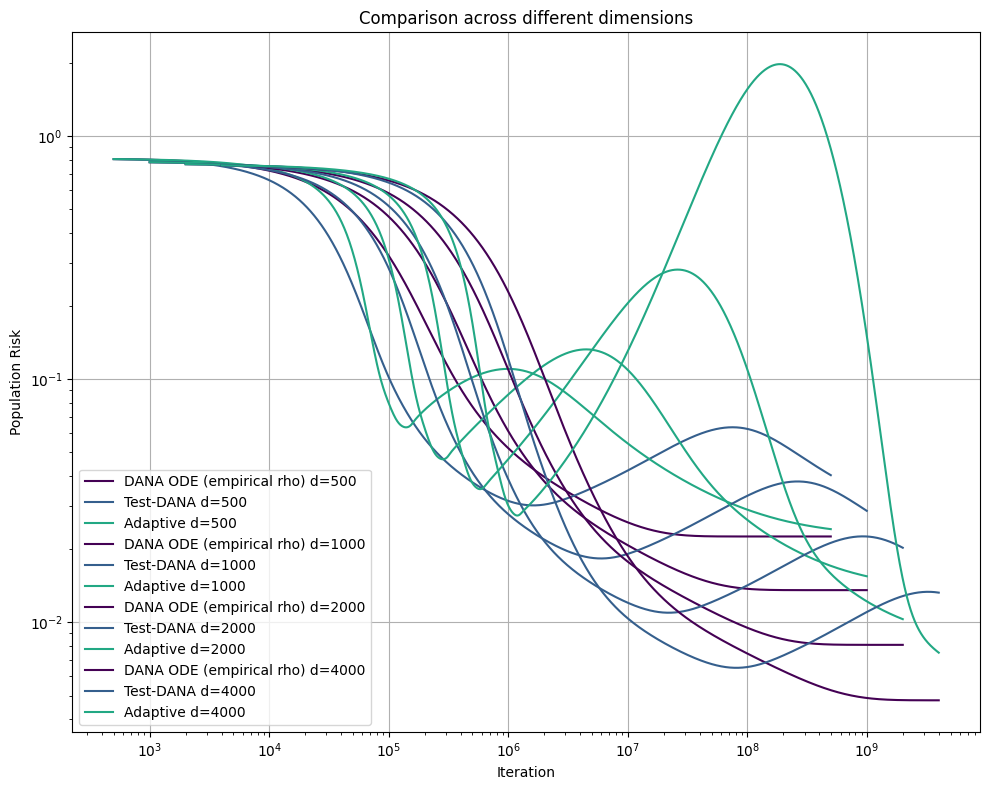

In [34]:
colors = plt.cm.viridis(jnp.linspace(0, 0.6, 3))  # Using 0 to 0.8 range for better visibility

# Plot all results on a single set of axes
plt.figure(figsize=(10, 8))
for data in all_data:
    plt.loglog(data['dana_times']*data['d'], data['dana_risks'], 
               color=colors[0],
               label=f"DANA ODE (empirical rho) d={data['d']}")
    plt.loglog(data['sgd_times']*data['d'], data['sgd_risks'], 
               color=colors[1],
               label=f"Test-DANA d={data['d']}")
    plt.loglog(data['adaptive_times']*data['d'], data['adaptive_risks'], 
               color=colors[2],
               label=f"Adaptive d={data['d']}")

plt.xlabel('Iteration')
plt.ylabel('Population Risk')
plt.title('Comparison across different dimensions')
plt.legend()
plt.grid(True)
plt.tight_layout()